In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import mrcfile
import time
try:
   import cupy as cp
except ImportError:
   use_cupy = True

In [2]:
fp = "/mnt/experiment/TEM diffraction/210312/sample53_TiGe15_bot_AD/Camera 230 mm Ceta 20210312 1755_50s_20f_area08.mrc"
# fp = "V:/experiment/210312/sample53_TiGe15_bot_AD/Camera 230 mm Ceta 20210312 1755_50s_20f_area08.mrc"

def load_mrc_img(fp):
    with mrcfile.open(fp) as mrc:
        raw_img = mrc.data
    easy_img = np.log(np.abs(raw_img)+1)
    easy_img = easy_img / easy_img.max() * 255
    easy_img = easy_img.astype('uint8')
    return raw_img, easy_img

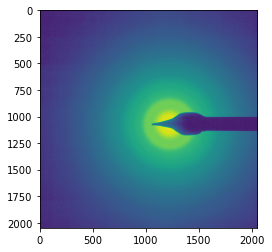

In [3]:
raw,img = load_mrc_img(fp)
plt.imshow(img)

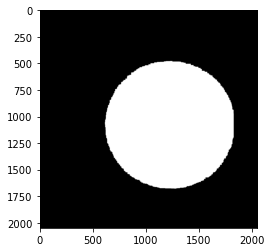

In [4]:
# blur = cv2.GaussianBlur(img, (5,5), 0)
def get_center(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
    plt.imshow(thresh)

    kernel = np.ones((20, 20), np.uint8)
    # thresh = cv2.erode(thresh,kernel, iterations=3)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    kernel = np.ones((200, 200), np.uint8)
    # thresh = cv2.erode(thresh,kernel, iterations=3)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    plt.imshow(thresh, cmap='gray')
    thresh = np.uint8(thresh / 255)

    mesh = np.meshgrid(np.arange(thresh.shape[0]), np.arange(thresh.shape[1]))
    center_x = np.sum(mesh[0] * thresh) / np.sum(thresh)
    center_y = np.sum(mesh[1] * thresh) / np.sum(thresh)
    return center_x, center_y

c_x, c_y = get_center(img)

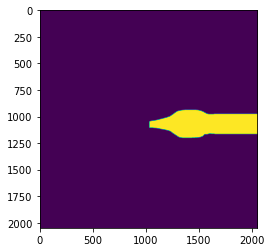

In [5]:
def create_estimated_mask(c_x,c_y):
    x1 = 900
    x2 = 1250
    y1 = 900
    # plt.imshow(img[x1:x2,y1:])
    img_slice = img[x1:x2,y1:]
    thresh = cv2.inRange(img_slice,0,130)
    thresh[0:100,700:]=0
    thresh[240:,700:]=0
    beam_mask = np.zeros(img.shape)
    beam_mask[x1:x2,y1:]=thresh

    c_x=np.uint16(c_x)
    c_y=np.uint16(c_y)

    kernel = np.ones((50,50),np.uint8)
    beam_mask = cv2.dilate(beam_mask,kernel,1)
    mask = cv2.circle(beam_mask, (c_x,c_y),50,255,-1)
    mask = np.uint8(mask)
    return mask

beam_mask = create_estimated_mask(c_x,c_y)
plt.imshow(beam_mask)

In [6]:
def rectangle(image,rng):
    i1, i2 = rng
    msk = cv2.inRange(image, i1, i2)
    kernel1 = np.ones((2, 2), np.uint8)
    msk = cv2.erode(msk,kernel1)
    nonzero = np.nonzero(msk)
    p1_y = nonzero[0].min()-2
    p1_x = nonzero[1].min()-2
    p2_y = nonzero[0].max()+2
    p2_x = nonzero[1].max()+2
    return (p1_y,p1_x,p2_y,p2_x)

In [7]:
def evaluate_center(img, center, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = 0
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = cv2.inRange(img,current_min_i,current_max_i)
        ring_mask = cv2.bitwise_and(ring_mask,ring_mask,mask=(np.logical_not(beam_mask)*255).astype(np.uint8))
        # 0.02

        mesh = np.meshgrid(range(img.shape[0]),range(img.shape[1]))
        mesh_x = mesh[0]-center_x
        mesh_y = mesh[1]-center_y
        # 0.03

        ring_x = cv2.bitwise_and(mesh_x,mesh_x,mask=ring_mask)
        ring_y = cv2.bitwise_and(mesh_y,mesh_y,mask=ring_mask)
        # 0.03


        dt = np.power(np.square(ring_x)+np.square(ring_y),0.5)
        dt = dt.reshape(-1)
        std_sum += np.std(dt[np.nonzero(dt)[0]])

    return std_sum

tic = time.clock()
print(evaluate_center(img,(c_x,c_y),(130,135),1))
toc = time.clock()
print(toc-tic)

8.175191273454582
0.08647500000000008


/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [101]:
def evaluate_center_slice(image, center, rect, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range

    p1_y,p1_x,p2_y,p2_x = rect

    y_width_origin = p2_y-p1_y
    x_width_origin = p2_x-p1_x
    h_y_width_origin = int(y_width_origin/2)
    h_x_width_origin = int(x_width_origin/2)

    p1y=np.max((center_y-h_y_width_origin,0)).astype(np.uint16)
    p2y=np.min((center_y+h_y_width_origin,image.shape[0])).astype(np.uint16)
    p1x=np.max((center_x-h_x_width_origin,0)).astype(np.uint16)
    p2x=np.min((center_x+h_x_width_origin,image.shape[1])).astype(np.uint16)

    y_width = p2_y-p1_y
    x_width = p2_x-p1_x
    h_y_width = int(y_width/2)
    h_x_width = int(x_width/2)

    slc_img = image[p1y:p2y,p1x:p2x]
    slc_beam_mask = beam_mask[p1y:p2y,p1x:p2x]

    # slc_beam_mask = beam_mask[center_y-h_y_width:center_y+h_y_width,center_x-h_x_width:center_x+h_x_width]
    slc_center_y = center_y - p1y
    slc_center_x = center_x - p1x

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = 0
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = cv2.inRange(slc_img,current_min_i,current_max_i)
        ring_mask = cv2.bitwise_and(ring_mask,ring_mask,mask=(np.logical_not(slc_beam_mask)*255).astype(np.uint8))

        mesh = np.meshgrid(range(slc_img.shape[1]),range(slc_img.shape[0]))
        mesh_y = mesh[1]-slc_center_y
        mesh_x = mesh[0]-slc_center_x

        ring_x = cv2.bitwise_and(mesh_x,mesh_x,mask=ring_mask)
        ring_y = cv2.bitwise_and(mesh_y,mesh_y,mask=ring_mask)

        dt = np.power(np.square(ring_x)+np.square(ring_y),0.5)
        dt = dt.reshape(-1)
        std_sum += np.std(dt[np.nonzero(dt)[0]])

    return std_sum

tic = time.clock()
intensity_rang = (130,135)
rectan = rectangle(img,intensity_rang)
print(evaluate_center_slice(img,(c_x,c_y),[0,0,4048,4048],intensity_rang,1))
toc = time.clock()
print(toc-tic)

8.175191273454582
0.10477799999999604


/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


min value: 7.904577153644997
min index: (4, 2)


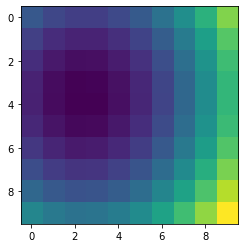

In [9]:
intensity_range = (130,135)

find_range = 5
xy = np.zeros((find_range*2,find_range*2))
for x in range(-find_range,find_range):
    for y in range(-find_range,find_range):
        xy[x+find_range,y+find_range]=evaluate_center(img,(c_x+x,c_y+y),intensity_range,1)

plt.imshow(xy)
print("min value:",xy.min())
print("min index:",np.unravel_index(xy.argmin(), xy.shape))

In [102]:
import itertools
tic = time.process_time()
intensity_range = (130,135)
rec = rectangle(img,intensity_range)

find_range = 5
nn = np.zeros((find_range*2,find_range*2))
x = np.arange(-find_range+int(c_x),+find_range+int(c_x))
y = np.arange(-find_range+int(c_y),+find_range+int(c_y))
n_xy = np.array(list(itertools.product(x,y)))
vectorized_method = np.vectorize(lambda c_xx,c_yy :evaluate_center_slice(img,(c_xx,c_yy),rec,intensity_range,5))
plt.imshow(vectorized_method(n_xy[:,0],n_xy[:,1]).reshape(nn.shape))

array([[28.27010536, 27.42910797, 27.06038823, 27.18060697, 27.78691385,
        28.84885625, 30.3177996 , 32.13793686, 34.25121823, 36.6038626 ],
       [27.00189385, 26.12691934, 25.74695459, 25.88079006, 26.52405922,
        27.64148853, 29.17779275, 31.07074687, 33.25744113, 35.68068724],
       [26.10539957, 25.20615003, 24.81936453, 24.96554715, 25.63887354,
        26.80002708, 28.38834921, 30.33661732, 32.57831609, 35.05385202],
       [25.62569373, 24.71579625, 24.32818484, 24.48425412, 25.17707285,
        26.36493717, 27.98410311, 29.96454594, 32.23782328, 34.74309952],
       [25.57923778, 24.67399313, 24.29196324, 24.45437724, 25.15381368,
        26.34841016, 27.9742171 , 29.9609979 , 32.24023074, 34.75101229],
       [25.9697233 , 25.08422241, 24.71382073, 24.8785997 , 25.57130236,
        26.75215977, 28.35991226, 30.32671903, 32.58583595, 35.07747866],
       [26.77447853, 25.921681  , 25.56820485, 25.73229902, 26.40733754,
        27.55729879, 29.12586512, 31.04974079

In [41]:
np.meshgrid(range(-5,5),range(-5,5))[0] + np.meshgrid(range(-5,5),range(-5,5))[1]

array([[-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1],
       [ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0],
       [ -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1],
       [ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2],
       [ -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3],
       [ -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4],
       [ -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5],
       [ -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6],
       [ -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7],
       [ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8]])

In [ ]:
for x in range(-find_range,find_range):
    for y in range(-find_range,find_range):
        xy[x+find_range,y+find_range]=evaluate_center_slice(img,(c_x+x,c_y+y),rec,intensity_range,5)
toc = time.process_time()
print(toc-tic)
        
plt.imshow(xy)
print("min value:",xy.min())
print("min index:",np.unravel_index(xy.argmin(), xy.shape))

In [99]:
def function_test(a,b):
    return str(a)+":"+str(b)
# np.vectorize(function_test)([[1,2],[3,4]],[[100],[200]])


(1215, 1073)
(1215, 1073)
(1215, 1074)
(1215, 1075)
(1215, 1076)
(1215, 1077)
(1215, 1078)
(1215, 1079)
(1215, 1080)
(1215, 1081)
(1215, 1082)
(1216, 1073)
(1216, 1074)
(1216, 1075)
(1216, 1076)
(1216, 1077)
(1216, 1078)
(1216, 1079)
(1216, 1080)
(1216, 1081)
(1216, 1082)
(1217, 1073)
(1217, 1074)
(1217, 1075)
(1217, 1076)
(1217, 1077)
(1217, 1078)
(1217, 1079)
(1217, 1080)
(1217, 1081)
(1217, 1082)
(1218, 1073)
(1218, 1074)
(1218, 1075)
(1218, 1076)
(1218, 1077)
(1218, 1078)
(1218, 1079)
(1218, 1080)
(1218, 1081)
(1218, 1082)
(1219, 1073)
(1219, 1074)
(1219, 1075)
(1219, 1076)
(1219, 1077)
(1219, 1078)
(1219, 1079)
(1219, 1080)
(1219, 1081)
(1219, 1082)
(1220, 1073)
(1220, 1074)
(1220, 1075)
(1220, 1076)
(1220, 1077)
(1220, 1078)
(1220, 1079)
(1220, 1080)
(1220, 1081)
(1220, 1082)
(1221, 1073)
(1221, 1074)
(1221, 1075)
(1221, 1076)
(1221, 1077)
(1221, 1078)
(1221, 1079)
(1221, 1080)
(1221, 1081)
(1221, 1082)
(1222, 1073)
(1222, 1074)
(1222, 1075)
(1222, 1076)
(1222, 1077)
(1222, 1078)

array([28.27010536, 27.42910797, 27.06038823, 27.18060697, 27.78691385,
       28.84885625, 30.3177996 , 32.13793686, 34.25121823, 36.6038626 ,
       27.00189385, 26.12691934, 25.74695459, 25.88079006, 26.52405922,
       27.64148853, 29.17779275, 31.07074687, 33.25744113, 35.68068724,
       26.10539957, 25.20615003, 24.81936453, 24.96554715, 25.63887354,
       26.80002708, 28.38834921, 30.33661732, 32.57831609, 35.05385202,
       25.62569373, 24.71579625, 24.32818484, 24.48425412, 25.17707285,
       26.36493717, 27.98410311, 29.96454594, 32.23782328, 34.74309952,
       25.57923778, 24.67399313, 24.29196324, 24.45437724, 25.15381368,
       26.34841016, 27.9742171 , 29.9609979 , 32.24023074, 34.75101229,
       25.9697233 , 25.08422241, 24.71382073, 24.8785997 , 25.57130236,
       26.75215977, 28.35991226, 30.32671903, 32.58583595, 35.07747866,
       26.77447853, 25.921681  , 25.56820485, 25.73229902, 26.40733754,
       27.55729879, 29.12586512, 31.04974079, 33.26559336, 35.71

In [12]:
np.meshgrid(range(5),range(5),range(5))[0][:3,:,:]*np.meshgrid(range(5),range(5))[0]
np.meshgrid(range(5),range(5))[0]

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [13]:
def evaluate_center_slice_range(image, center, rect, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range
    shift_range = 5

    p1_y,p1_x,p2_y,p2_x = rect

    y_width_origin = p2_y-p1_y
    x_width_origin = p2_x-p1_x
    h_y_width_origin = int(y_width_origin/2)
    h_x_width_origin = int(x_width_origin/2)

    p1y=np.max((center_y-h_y_width_origin,0)).astype(np.uint16)
    p2y=np.min((center_y+h_y_width_origin,image.shape[0])).astype(np.uint16)
    p1x=np.max((center_x-h_x_width_origin,0)).astype(np.uint16)
    p2x=np.min((center_x+h_x_width_origin,image.shape[1])).astype(np.uint16)

    y_width = p2_y-p1_y
    x_width = p2_x-p1_x
    h_y_width = int(y_width/2)
    h_x_width = int(x_width/2)

    slc_img = image[p1y:p2y,p1x:p2x]
    slc_beam_mask = beam_mask[p1y:p2y,p1x:p2x]

    # slc_beam_mask = beam_mask[center_y-h_y_width:center_y+h_y_width,center_x-h_x_width:center_x+h_x_width]
    slc_center_y = h_y_width
    slc_center_x = h_x_width
    slc_center_y = center_y - p1y
    slc_center_x = center_x - p1x

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = 0
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = cv2.inRange(slc_img,current_min_i,current_max_i)
        ring_mask = cv2.bitwise_and(ring_mask,ring_mask,mask=(np.logical_not(slc_beam_mask)*255).astype(np.uint8))

        mesh = np.meshgrid(range(slc_img.shape[1]),range(slc_img.shape[0]))
        mesh_y = mesh[1]-slc_center_y
        mesh_x = mesh[0]-slc_center_x

        ring_x = cv2.bitwise_and(mesh_x,mesh_x,mask=ring_mask)
        ring_y = cv2.bitwise_and(mesh_y,mesh_y,mask=ring_mask)
        
        dt = np.power(np.square(ring_x)+np.square(ring_y),0.5)
        dt = dt.reshape(-1)
        std_sum += np.std(dt[np.nonzero(dt)[0]])

    return std_sum

tic = time.clock()
intensity_rang = (130,135)
rectan = rectangle(img,intensity_rang)
print(evaluate_center_slice_range(img,(c_x,c_y),[0,0,4048,4048],intensity_rang,1))
toc = time.clock()
print(toc-tic)

8.175191273454582
0.1026270000000018


/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [14]:
def evaluate_center_slice_range_cupy(image, center, rect, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range
    shift_range = 7

    p1_y,p1_x,p2_y,p2_x = rect

    y_width_origin = p2_y-p1_y
    x_width_origin = p2_x-p1_x
    h_y_width_origin = int(y_width_origin/2)
    h_x_width_origin = int(x_width_origin/2)

    p1y=np.max((center_y-h_y_width_origin,0)).astype(np.uint16)
    p2y=np.min((center_y+h_y_width_origin,image.shape[0])).astype(np.uint16)
    p1x=np.max((center_x-h_x_width_origin,0)).astype(np.uint16)
    p2x=np.min((center_x+h_x_width_origin,image.shape[1])).astype(np.uint16)

    y_width = p2_y-p1_y
    x_width = p2_x-p1_x
    h_y_width = int(y_width/2)
    h_x_width = int(x_width/2)

    slc_img = cp.array(image[p1y:p2y,p1x:p2x])
    slc_beam_mask = cp.array(beam_mask[p1y:p2y,p1x:p2x])

    # slc_beam_mask = beam_mask[center_y-h_y_width:center_y+h_y_width,center_x-h_x_width:center_x+h_x_width]
    slc_center_y = h_y_width
    slc_center_x = h_x_width
    slc_center_y = center_y - p1y
    slc_center_x = center_x - p1x

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = cp.zeros((shift_range*2,shift_range*2))
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = (current_max_i >= slc_img) & (slc_img > current_min_i)
        ring_mask = ring_mask & cp.bitwise_not(slc_beam_mask)
#         ring_mask = ring_mask.astype('float')
#         cp.putmask(ring_mask,ring_mask==0,cp.nan)
#         print(cp.sum(ring_mask==np.nan))
#         plt.imshow(ring_mask.get())
        mesh = cp.meshgrid(cp.arange(-slc_center_x,-slc_center_x+slc_img.shape[1]),
                           cp.arange(-slc_center_y,-slc_center_y+slc_img.shape[0]))
        new_mesh_y = mesh[1][:,:,None]+cp.arange(-shift_range,shift_range)
        new_mesh_x = mesh[0][:,:,None]+cp.arange(-shift_range,shift_range)
        new_mesh_y = new_mesh_y.transpose(2,0,1)
        new_mesh_x = new_mesh_x.transpose(2,0,1)
        
        
        ring_x = new_mesh_x*ring_mask
        ring_y = new_mesh_y*ring_mask
        
        ring_x = cp.square(ring_x)
        ring_y = cp.square(ring_y)
        
        ring_xy = ring_x[:,:,:,None]+cp.zeros(2*shift_range)
        ring_xy = ring_xy.transpose(0,3,1,2)
        ring_xy = cp.add(ring_xy,ring_y)
        print((ring_xy[0,:,:]-ring_xy[1,:,:]).std())
        
        ring_xy = cp.power(ring_xy,0.5)
        
        dt = cp.where(ring_xy!=0,ring_xy,cp.nan)
        std_sum += cp.nanstd(dt,axis=(2,3))
        
        
    std_sum = std_sum.get()
    return std_sum

tic = time.process_time()
intensity_rang = (130,135)
rectan = rectangle(img,intensity_rang)
picture = evaluate_center_slice_range_cupy(img,(c_x,c_y),[0,0,4048,4048],intensity_rang,1)
toc = time.process_time()
print(toc-tic)

63.558576999768995
2.9776914770000005


min value: 6.66656157565832
min index: (8, 10)


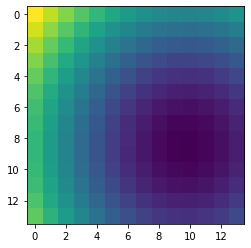

In [15]:
plt.imshow(picture)
print("min value:",picture.min())
print("min index:",np.unravel_index(picture.argmin(), picture.shape))

In [16]:
a = np.meshgrid(range(5),range(5),range(5))[0]
b = np.meshgrid(range(5),range(5),range(5))[2]
a = a[:,:,:,None]+np.zeros(3)
a = a.transpose(3,0,1,2)
np.add(a,b)
a[0]

array([[[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]],

       [[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]],

       [[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]],

       [[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]],

       [[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]]])

In [17]:
# imagine = cp.ones((img.shape[0],img.shape[1]))[None,:,:]*cp.arange(0,10)
# imagine = imagine.transpose(2,0,1)
# # imagine = None
# print(mempool.used_bytes()/1024/1024)              # 0
# print(mempool.total_bytes()/1024/1024)             # 0

In [18]:
# meshgrid = cp.meshgrid(cp.arange(-c_x,-c_x+img.shape[0]),cp.arange(-c_y,-c_y+img.shape[1]))
# mesh_x = meshgrid[0][:,:,None]+cp.arange(-10,10)
# mesh_y = meshgrid[0][:,:,None]+cp.arange(-10,10)

In [19]:
# # np.array(10).transpose(1,-1)
# a = np.arange(75).reshape(5,5,3)[:,:,:,None]+np.zeros(10)
# a = a.transpose(3,0,1,2)
# b = np.arange(75).reshape(5,5,3)
# np.add(a,b)
# np.nonzero(np.array([[1,2,0,3,4],[2,3,1,0,4]]))

In [20]:
# mempool = cp.get_default_memory_pool()
# pinned_mempool = cp.get_default_pinned_memory_pool()
# # mempool.used_bytes()
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()
# print(mempool.used_bytes()/1024/1024)              # 0
# print(mempool.total_bytes()/1024/1024)             # 0
# print(pinned_mempool.n_free_blocks())    # 0

In [21]:
#     nazav = np.zeros((n_rr+1,1))
#     azav = np.zeros((n_rr+1,1))
# tic = time.clock()
# for n in range(1,n_rr) :
#     rig_mask = np.uint8(rr==n)
#     rig = cv2.bitwise_and(image,image,mask=rig_mask)
#     # rig = image*rig_mask
#     rig = rig.reshape((-1))
#     non_zero = np.nonzero(rig)[0]
#     azav[n] = np.average(rig[non_zero])
# toc = time.clock()
# print(toc-tic)

In [22]:
def get_azimuthal_mean(raw_image, center):
    center_x, center_y = center
    mesh = np.meshgrid(range(raw_image.shape[1]),range(raw_image.shape[0]))
    mesh_x = mesh[0] - center_x
    mesh_y = mesh[1] - center_y
    rr = np.power(np.square(mesh_x)+np.square(mesh_y),0.5)
    rr = cv2.bitwise_and(rr,rr,mask=np.bitwise_not(beam_mask))
    n_rr = np.uint16(np.ceil(rr.max()))
    
    f = lambda r : raw_image[(rr >= r-.5) & (rr < r+.5)].mean()
    r  = np.linspace(1,n_rr,num=n_rr)
    mean = np.vectorize(f)(r)
    mean = np.nan_to_num(mean,0)
    return mean

In [23]:
def get_azimuthal_mean_cupy(raw_image,center):
    img = cp.array(raw_image)
    beam = cp.array(beam_mask)
    center_x, center_y = center
    
    mesh = cp.meshgrid(cp.arange(raw_image.shape[1]),cp.arange(raw_image.shape[0]))
    mesh_x = mesh[0] - center_x
    mesh_y = mesh[1] - center_y
    rr = cp.power(cp.square(mesh_x)+cp.square(mesh_y),0.5)
    cp.putmask(rr, beam, 0)
    n_rr = int(cp.ceil(rr.max()))
    
    azav = cp.zeros((n_rr+1))
    for n in range(1,n_rr) :
        rig_mask = (rr >= n-0.5) & (rr < n+0.5)
        rig = img*rig_mask
        rig = rig.reshape((-1))
        non_zero = cp.nonzero(rig)[0]
        azav[n] = cp.average(rig[non_zero])
    azav = np.nan_to_num(azav.get(),0)
    return azav

/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


0.8504939999999976


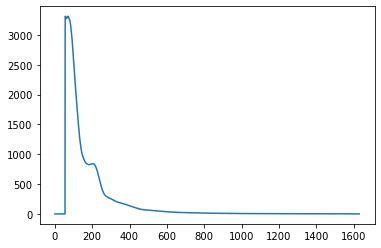

In [24]:
tic = time.clock()
az_mean = get_azimuthal_mean_cupy(raw,(c_x,c_y))
toc = time.clock()
print(toc-tic)
plt.plot(az_mean)

/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed 

6.652565000000003


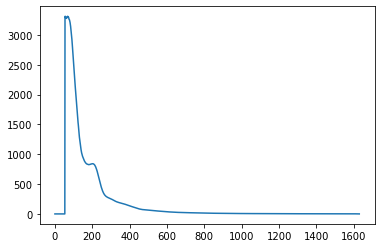

In [25]:
tic = time.clock()
az_mean = get_azimuthal_mean(raw,(c_x,c_y))
toc = time.clock()
print(toc-tic)
plt.plot(az_mean)

In [26]:
# tic = time.clock()
# for yy in range(image.shape[0]):
#     for xx in range(image.shape[1]):
#         kk = rr[yy,xx]
#         if kk==0: continue
#         nazav[kk]+=1
#         azav[kk]+=image[yy,xx]
# for r in range(n_rr):
#     azav[r] = azav[r]/nazav[r]
# toc = time.clock()
# print(toc-tic)



In [27]:
newX = np.ma.array(np.array([1,2,3,4]), mask = [1,0,1,0])

In [28]:
newX.min()

2

In [29]:
cupy.putmask(x, x>2, x**2)

NameError: name 'cupy' is not defined

In [ ]:
colorcube = np.loadtxt("./assets/colorcube.csv",delimiter=",",dtype=np.float32)
def gray2colorcube(img, cmap):
    assert len(img.shape)==2 # img should be gray img
    if img.dtype != np.uint8:
        print("rescale to uint8")
        img = img / np.max(img) * len(cmap)
        img = img.astype(np.uint8)

    new_img = np.zeros((img.shape[0],img.shape[1],3))
#     for idx, val in np.ndenumerate(img):
#         new_img[idx] = colorcube[val]
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            new_img[x,y] = colorcube[img[x,y]]
    return new_img